# Intro to RL
Matteo Bunino - CERN openlab summer lectures 2024

#### Acknowledegments

- [Reinforcement Learning: an introduction](http://incompleteideas.net/book/the-book-2nd.html)
- [Gymnasium](https://gymnasium.farama.org/)
- [Felix Wagner's lecture](https://github.com/fewagner/icsc23/blob/main/1_mock_mdp.ipynb)
- DQN [tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [1]:
# !pip install swig 1> /dev/null
# !pip install gymnasium[all] 1> /dev/null

import gymnasium as gym
from gymnasium import spaces
import numpy as np

from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Markov Decision Process (MDP)

Let's consider the MDP depicted below 

<div>
<img src="img/MDP.png" width="500"/>
</div>

In [2]:
# p(s', r | s, a)
MDP_DYNAMICS = [
    # state 0
    [
        # action 0
        [
            # transition_probability, next_state, reward, terminal
            [0.5, 0, 0.0, False],
            [0.5, 2, 0.0, False],
        ],
        # action 1
        [
            [1.0, 2, 0.0, False]
        ]
    ],
    # state 1
    [
        # action 0
        [
            [0.7, 0, 5.0, False],
            [0.1, 1, 0.0, False],
            [0.2, 2, 0.0, False]
        ],
        # action 1
        [
            [0.95, 1, 0.0, False],
            [0.05, 2, 0.0, False]
        ]
    ],
    # state 2
    [
        # action 0
        [
            [0.4, 0, 0.0, False],
            [0.6, 2, 0.0, False]
        ],
        # action 1
        [
            [0.3, 0, -1.0, False],
            [0.3, 1, 0.0, False],
            [0.4, 2, 0.0, False],
        ]
    ]
]

# Inspect
state = 1
action = 0

MDP_DYNAMICS[state][action]

[[0.7, 0, 5.0, False], [0.1, 1, 0.0, False], [0.2, 2, 0.0, False]]

### 1.1 Defind MDP above as Gymnasium environment

In [3]:
class MDPEnv(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}
    NMBR_STATES = 3
    NMBR_ACTIONS = 2

    def __init__(self, seed: int = None):
        super(MDPEnv, self).__init__()
        self.rng = np.random.default_rng(seed)
        self.action_space = spaces.Discrete(self.NMBR_ACTIONS) 
        self.observation_space = spaces.Discrete(self.NMBR_STATES) 
        self.state = None
        self.P = MDP_DYNAMICS
        
    def step(self, action):
        
        info = {}
        truncated = False
        
        dynamics = np.array(self.P[self.state][action])
        _, new_state, reward, terminal = self.rng.choice(dynamics, p=dynamics[:, 0])
        new_state = int(new_state)
        terminal = bool(terminal)        
        self.state = new_state
        
        return new_state, reward, terminal, truncated, info
    
    def reset(self, state=None):
        info = {}
        if state is None:
            self.state = self.rng.integers(self.NMBR_STATES)
        else:
            self.state = state
        
        return self.state, info
        
    def render(self):
        print('Current state: ', self.state)

### 1.2 Explore the environment

In [4]:
env =  MDPEnv()

observation, info = env.reset()

# Let's perform 10 interactions with the environment
for _ in range(10):
    # Use a random policy
    action = np.random.randint(2)

    # Take action and print: next_state and reward
    observation, reward, terminal, truncated, info = env.step(action)
    print(observation, reward)

1 0.0
0 5.0
2 0.0
2 0.0
2 0.0
2 0.0
1 0.0
1 0.0
1 0.0
1 0.0


Under the random policy, estimate the average return for each state:

1. Run $N$ episodes. starting from an initial random state
    1. For each episode, perform $T$ steps
    2. In the same episode, compute the returns for each state and average them
2. Average the state returns across all episodes

#### Definition of Return

<div>
<img src="img/return.png" width="500"/>
</div>
where $\gamma \in [0,1)$ is the discount factor and $R_t$ is the reward at step $t$.

<br><br>

Graphical representation:
<div>
<img src="img/return_graphics.png" width="800"/>
</div>

In [5]:
env =  MDPEnv()

gamma = 0.99
num_episodes = 20
T = 1000

global_state_returns = [[] for _ in range(env.NMBR_STATES)]
for _ in range(num_episodes):
    transitions = []
    # Reset to an initial random state
    state, _ = env.reset()
    
    # Run an episode
    for _ in range(T):
        # Use a random policy
        ...
    
        # Take action
        ...

        # Record transition
        transitions.append((state, action, reward, next_state))
        state = next_state

    # Compute state returns
    state_returns = [[] for _ in range(env.NMBR_STATES)]
    g = 0
    # Unroll the episode from the end computing the rewards backwards
    ...
    
    # Average returns within this episode    
    ...

# Average returns across all episodes    
...

global_state_returns

[np.float64(18.61709520149803),
 np.float64(21.8172439984229),
 np.float64(18.88703353940377)]

### 1.3 Policy evaluation: $V \approx v_\pi$

<div>
<img src="img/policy_eval.png" width="700"/>
</div>

From the "RL book" - chapt. 4

#### Evaluate the random policy

In [6]:
def policy_evaluation(env, policy, gamma, theta, v):
    """Compute state value function under the given policy.

    Args:
        env (MDPEnv): MDP environment.
        policy (np.ndarray): matrix for discrete policy with shape (NUM_ACTIONS, NUM_STATES). pi(a|s) = policy[a, s]
        gamma (float): discount factor.
        theta (float): aprroximation tolerance.
        v (np.ndarray): initial state values.

    Returns:
        np.ndarray: state values under the given policy.
    """
    num_actions, num_states = policy.shape
    delta = theta + 1
    while delta > theta:
        delta = 0    
        for s in range(num_states):
            old_v_s = v[s]
            new_v_s = 0
            ...
            
            delta = max(delta, np.abs(new_v_s - old_v_s))
            v[s] = new_v_s
    return v


# Define a random policy: pi(a|s) = pi[a, s]
policy = np.ones((env.NMBR_ACTIONS, env.NMBR_STATES)) / env.NMBR_ACTIONS
v = np.zeros(env.NMBR_STATES)
gamma = 0.99 # Discount factor
theta = 0.000001 # Tolerance

policy_evaluation(env, policy, gamma, theta, v)

array([20.18373883, 23.47744357, 20.45557502])

### 1.4 Value iteration

Let's find the optimal policy $\pi_*$

<div>
<img src="img/value_iteration.png" width="700"/>
</div>

From the "RL book" - chapt. 4

#### Compute the optimal policy

In [7]:
def value_iteration(env, gamma, theta, v, num_actions):
    """Compute the optimal policy.

    Args:
        env (MDPEnv): MDP environment.
        gamma (float): discount factor.
        theta (float): aprroximation tolerance.
        v (np.ndarray): initial state values.
        num_actions (int): dimensionality of action space.

    Returns:
        np.ndarray: matrix for discrete policy with shape (NUM_ACTIONS, NUM_STATES). pi(a|s) = policy[a, s]
    """
    num_states = len(v)
    delta = theta + 1
    # TODO: implement the policy evaluation with max

    # Compute optimal greedy policy
    pi_star = np.zeros((num_actions, num_states))
    ...
    return pi_star

v = np.zeros(env.NMBR_STATES)
gamma = 0.99 # Discount factor
theta = 0.000001 # Tolerance

pi_star = value_iteration(env, gamma, theta, v, env.NMBR_ACTIONS)

print("pi*:\n", pi_star, '\n')

v_star = policy_evaluation(env, pi_star, gamma, theta, v)
print("V*: ", v_star)

pi*:
 [[0. 1. 0.]
 [1. 0. 1.]] 

V*:  [45.56054293 49.0405824  46.0207514 ]


## 2. Monte Carlo methods

### Epsilon-greedy policy

In [8]:
def argmax_break_ties(array, rng=None) -> int:
    """
    Argmax but breaks ties randomly.

    Args:
        array: 1-dimensional array.
        rng: random number generator. Defaul None.

    Returns:
        int: the argmax index in the input array.
    """
    curr_max = None
    max_candidates = []
    for idx, el in enumerate(array):
        if curr_max is None or el > curr_max:
            curr_max = el
            max_candidates = [idx]
        elif el == curr_max:
            max_candidates.append(idx)
        else:
            pass

    if rng is not None:
        return rng.choice(max_candidates)
    return np.random.choice(max_candidates)

def epsilon_greedy(state_values, epsilon: float) -> int:
    """
    Sample action using epsilon-greedy policy.

    Args:
        state_values: 1-dimensional array.
        epsilon (float): epsilon.

    Returns:
        int: the action ID.
    """
    if np.random.rand() < epsilon:
        return np.random.randint(len(state_values))
    return argmax_break_ties(state_values)

# Test the epsilon_greedy action sampler
epsilon_greedy([1,1,1,1], epsilon=.9)

0

### 2.1 Implement the Monte Carlo control algorithm


<div>
<img src="img/mc_control.png" width="700"/>
</div>


In [ ]:
# TODO: at home

## 3. TD(0) methods

### 3.1 SARSA (on-polict TD control)

<div>
<img src="img/sarsa_control.png" width="700"/>
</div>

We will use the [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) environment.

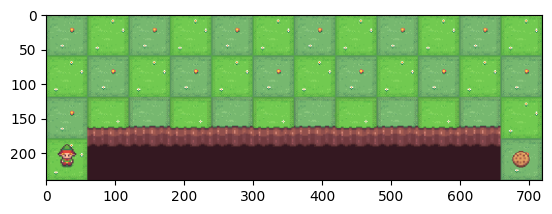

In [311]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()
img = plt.imshow(env.render())

In [312]:
env = gym.make("CliffWalking-v0")
q_table = np.zeros((env.observation_space.n, env.action_space.n))

In [227]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


#### Train the agent

Play around with the parameters below!

In [231]:
N_EPISODES = 10000
EPSILON = 0.1   # 10% of times take a random action
ALPHA = 0.1     # learing rate
GAMMA = 0.99    # discount factor

for _ in range(N_EPISODES):
    state, _ = env.reset()

    # Choose epsion-greedy action
    action = epsilon_greedy(q_table[state], epsilon=EPSILON)

    while True:
        # TODO: implement logic for each episode below

        # Take actions
        ...

        # Update Q-table
        ...

        # Record transition
        state = next_state
        action = next_action

In [232]:
sarsa_q_table = q_table
sarsa_q_table

array([[ -15.34734136,  -14.22538572,  -16.46406566,  -15.44857713],
       [ -14.33799201,  -13.21204282,  -15.11724688,  -15.50478669],
       [ -13.43460541,  -12.20763735,  -13.62547246,  -14.56498781],
       [ -12.53620244,  -11.29843096,  -12.18547257,  -13.7339734 ],
       [ -11.56326629,  -10.58877846,  -11.23803954,  -12.71168395],
       [ -10.48808897,   -9.35433257,  -10.22487042,  -11.67211678],
       [  -9.51142667,   -8.42115069,   -9.07308968,  -10.68306568],
       [  -8.59120703,   -7.47595292,   -7.80858027,   -9.72132005],
       [  -7.47074001,   -6.52194508,   -7.09219287,   -8.82062282],
       [  -6.74112391,   -5.78309038,   -5.69930408,   -7.66210919],
       [  -5.58582525,   -4.52940616,   -4.8512474 ,   -6.69097353],
       [  -4.3396499 ,   -4.29651552,   -3.43617329,   -5.60185106],
       [ -15.19923883,  -15.76992961,  -17.41279373,  -16.13640664],
       [ -14.76767996,  -14.2399358 ,  -19.53016301,  -15.80482617],
       [ -13.27939819,  -13.449813

#### Avoid the cliff!

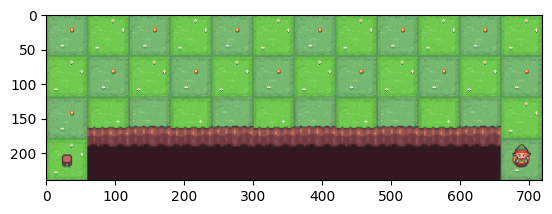

In [233]:
# Interact with the environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
state, _ = env.reset()
img = plt.imshow(env.render())

while True:
    # Choose a greedy action, not epsilon greedy
    action = np.argmax(sarsa_q_table[state])
    next_state, reward, terminal, _, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminal:
        break
    state = next_state
    action = np.argmax(sarsa_q_table[state])

### 3.2 Q-learning (off-polict TD control)

<div>
<img src="img/q_control.png" width="700"/>
</div>

Again,we will use the [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) environment.

In [234]:
env = gym.make("CliffWalking-v0")
q_table = np.zeros((env.observation_space.n, env.action_space.n))

In [235]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


#### Train the agent

Play around with the parameters below!

In [236]:
N_EPISODES = 1000
EPSILON = 0.1   # 10% of times take a random action
ALPHA = 0.1     # learing rate
GAMMA = 0.99    # discount factor

for _ in range(N_EPISODES):
    state, _ = env.reset()

    while True:
        # Choose epsion-greedy action
       ...
        

        # Update Q-table
        ...

        # Record transition
        state = next_state


In [237]:
qlearning_q_table = q_table
qlearning_q_table

array([[ -10.97756899,  -10.94380981,  -10.90864274,  -11.01716066],
       [ -10.64090445,  -10.50577506,  -10.6070964 ,  -10.52738078],
       [  -9.92125097,   -9.91291593,   -9.93613056,   -9.91589636],
       [  -9.21122926,   -9.23296748,   -9.33666378,   -9.39276449],
       [  -8.5911513 ,   -8.53119629,   -8.57132004,   -8.67067841],
       [  -7.7486223 ,   -7.74706351,   -7.77856037,   -8.04988094],
       [  -7.10288257,   -6.97576493,   -6.97402101,   -7.15062732],
       [  -6.1925755 ,   -6.17886612,   -6.21827476,   -6.23653273],
       [  -5.51546925,   -5.36451587,   -5.37813943,   -5.48489692],
       [  -4.57866242,   -4.56741709,   -4.55680262,   -4.64063139],
       [  -3.80766024,   -3.76310562,   -3.75727976,   -3.80511171],
       [  -2.9423498 ,   -3.02494506,   -2.93830196,   -3.07904871],
       [ -11.33045869,  -11.34628669,  -11.35592656,  -11.3523687 ],
       [ -10.84310299,  -10.78272022,  -10.78315823,  -10.82069048],
       [ -10.14483016,  -10.096515

#### Avoid the cliff!

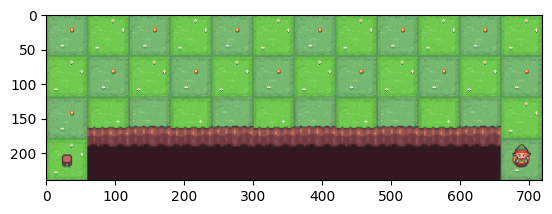

In [238]:
# Interact with the environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
state, _ = env.reset()
img = plt.imshow(env.render())

while True:
    # Choose a greedy action, not epsilon greedy
    action = np.argmax(qlearning_q_table[state])
    next_state, reward, terminal, _, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminal:
        break
    state = next_state

### 3.3 SARSA vs. Q-learning

Did you notice any differences between the behaviors of SARSA and Q-learning agents?

#### SARSA

In [ ]:
# SARSA
# Interact with the environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
state, _ = env.reset()
img = plt.imshow(env.render())

while True:
    # Choose a greedy action, not epsilon greedy
    action = np.argmax(sarsa_q_table[state])
    next_state, reward, terminal, _, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminal:
        break
    state = next_state
    action = np.argmax(sarsa_q_table[state])

#### Q-learning

In [ ]:
# Q-learning
# Interact with the environment
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
state, _ = env.reset()
img = plt.imshow(env.render())

while True:
    # Choose a greedy action, not epsilon greedy
    action = np.argmax(qlearning_q_table[state])
    next_state, reward, terminal, _, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if terminal:
        break
    state = next_state

#### Compare the rewards over time: SARSA vs. Q-learning

In [300]:
N_EPISODES = 1000
EPSILON = 0.1   # 10% of times take a random action
ALPHA = 0.1     # learing rate
GAMMA = 0.99    # discount factor

# SARSA
sarsa_rewards = []
env = gym.make("CliffWalking-v0")
q_table = np.zeros((env.observation_space.n, env.action_space.n))

for _ in range(N_EPISODES):
    state, _ = env.reset()
    tot_reward  = 0

    # Choose epsion-greedy action
    action = epsilon_greedy(q_table[state], epsilon=EPSILON)

    while True:
        next_state, reward, terminal, _, _ = env.step(action)
        tot_reward += reward
        
        # Train SARSA
        ...

        # Record transition
        state = next_state
        action = next_action
    
    sarsa_rewards.append(tot_reward)

# Q-learning
qlearning_rewards = []
env = gym.make("CliffWalking-v0")
q_table = np.zeros((env.observation_space.n, env.action_space.n))

for _ in range(N_EPISODES):
    state, _ = env.reset()
    tot_reward = 0

    while True:
        # Choose epsion-greedy action
        action = epsilon_greedy(q_table[state], epsilon=EPSILON)
        
        next_state, reward, terminal, _, _ = env.step(action)
        tot_reward += reward

        # Train Q-learning
        ...

        # Record transition
        state = next_state
    
    qlearning_rewards.append(tot_reward)

In [301]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

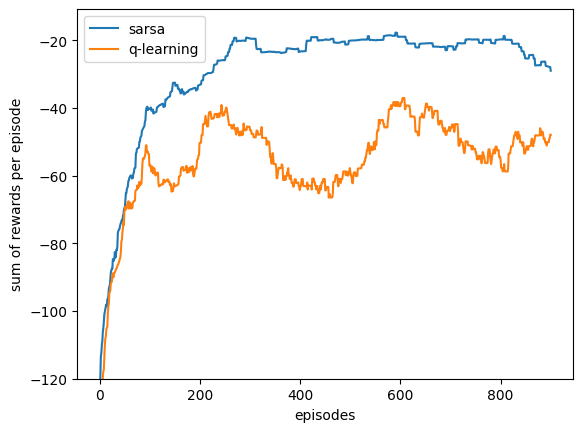

In [305]:
ax = plt.axes()
ax.plot(moving_average(sarsa_rewards, 100), label='sarsa')
ax.plot(moving_average(qlearning_rewards, 100), label='q-learning')
ax.set_ybound(-120)
ax.legend()
ax.set_ylabel("sum of rewards per episode")
ax.set_xlabel("episodes")
plt.show()

## 4. Q-learning with function approximation
We will use the [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment.

In [19]:
import torch
from torch import nn
from collections import deque, namedtuple
import random
from tqdm import tqdm

Initial state:  [ 2.6998520e-04  1.4058478e+00  2.7337009e-02 -2.2543298e-01
 -3.0611295e-04 -6.1922641e-03  0.0000000e+00  0.0000000e+00]


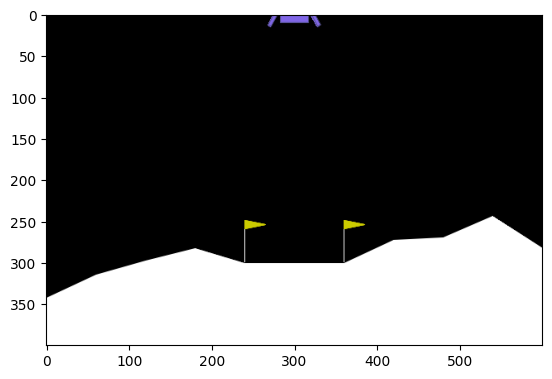

In [7]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
state, info = env.reset()
print("Initial state: ", state)

img = plt.imshow(env.render())

In [8]:
env.observation_space.shape, env.action_space

((8,), Discrete(4))

#### Define the neural network to estimate the value function

In [9]:
class QNet(nn.Module):
    def __init__(self, state_size: int, n_actions: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )
    def forward(self, x):
        return self.layers(x)

Compute action values of state $S=(0,0,0,0,0,0,0,0)$ using randomly initialized (untrained) `QNet`:

In [10]:
model = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)
model(torch.zeros(1, env.observation_space.shape[0]))

tensor([[ 0.0271,  0.0267, -0.0598, -0.1005]], grad_fn=<AddmmBackward0>)

#### Replay memory

In [11]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, next_state, reward):
        """Save a transition"""
        self.memory.append(Transition(state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Check how `ReplayMemory` works:

In [12]:
replay_memory = ReplayMemory(2)

replay_memory.push(state=1, action=1, next_state=1, reward=1)
replay_memory.push(2, 2, 2, 2)

print(replay_memory.sample(2))

print("\nAfter exceeding memory size:")
replay_memory.push(3, 3, 3, 3)
replay_memory.push(4, 5, 6, 7)
print(replay_memory.sample(2))

[Transition(state=2, action=2, next_state=2, reward=2), Transition(state=1, action=1, next_state=1, reward=1)]

After exceeding memory size:
[Transition(state=4, action=5, next_state=6, reward=7), Transition(state=3, action=3, next_state=3, reward=3)]


#### Epsilon greedy policy

In [13]:
def epsilon_greedy_nn(state_values, policy_net: nn.Module, epsilon: float) -> int:
    """
    Sample action using epsilon-greedy policy with state values with function approximation.

    Args:
        state_values: 1-dimensional array.
        policy_net (nn.Module): torch neural network.
        epsilon (float): epsilon.

    Returns:
        int: the action ID.
    """
    if np.random.rand() < epsilon:
        return np.random.randint(state_values.shape[0])
    with torch.no_grad():
        return policy_net(state).max(1).indices.item()

Get familiar with `policy_net` and $\epsilon$-greedy policies:

In [14]:
# Policy net
model = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)

state, info = env.reset()
state = torch.tensor(state).unsqueeze(0)
print("State: ", state)

# Proportional to the 
print("Action values: ", model(state))

# Force greedy action (epsilon = 0)
epsilon_greedy_nn(state, policy_net=model, epsilon=0)

# Does the greedy action correspond with the index of the highest action value?

State:  tensor([[ 0.0037,  1.4199,  0.3798,  0.4004, -0.0043, -0.0860,  0.0000,  0.0000]])
Action values:  tensor([[-0.0939, -0.1516,  0.1091, -0.0464]], grad_fn=<AddmmBackward0>)


2

#### Compute the loss

In [15]:
def compute_loss(transitions_batch: Transition, policy_net: nn.Module, target_net: nn.Module):
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, transitions_batch.next_state)),
                                  dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in transitions_batch.next_state if s is not None])
    state_batch = torch.cat(transitions_batch.state)
    action_batch = torch.cat(transitions_batch.action)
    reward_batch = torch.cat(transitions_batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(-1))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    return loss

#### Train the agent

In [54]:
# Hyperparameters
MEMORY_SIZE = 100_000     # size of replay buffer
GAMMA = 0.995             # discount factor
EPSILON = 0.1             # take a random action 10% of the times
ALPHA = 1e-3              # learning rate
LEARN_EVERY = 4           # perform a learning update every C time steps
UPDATE_TARGET_EVERY = 4
NUM_EPISODES = 300
BATCH_SIZE = 128
MAX_EPISODE_LENGTH = 450

env = gym.make('LunarLander-v2')

replay_memory = ReplayMemory(MEMORY_SIZE)

policy_net = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)
target_net = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)
# Copy weights
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=ALPHA)

In [55]:
episodes_reward = []
episodes_length = []
tot_steps = 0
optim_steps = 0
for _ in tqdm(range(NUM_EPISODES)):
    tot_reward = 0
    episode_length = 0
    state, info = env.reset()
    state = torch.tensor(state).unsqueeze(0)
    for _ in range(MAX_EPISODE_LENGTH):
        # Choose action (epsilon-greedy)
        ...
        
        # Take action
        ...
        
        # Record transition
        tot_reward += reward
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state).unsqueeze(0)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        replay_memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Optimize the QNet
        if len(replay_memory) >= BATCH_SIZE*2 and tot_steps % LEARN_EVERY == 0:
            transitions_batch = replay_memory.sample(BATCH_SIZE)
            # Transpose the tuples
            transitions_batch = Transition(*zip(*transitions_batch))

            # Compute loss and perform backpropagation
            ...

            optim_steps += 1
            if optim_steps % UPDATE_TARGET_EVERY == 0:
                # Copy policy net weights into target net
                ...

        tot_steps += 1

        if terminated or truncated:
            episode_length += 1
            break
        episode_length += 1

    episodes_length.append(episode_length)
    episodes_reward.append(tot_reward)

# Save model
torch.save(policy_net.state_dict(), "QNet_weights.pth")

100%|██████████| 200/200 [1:17:47<00:00, 23.34s/it]


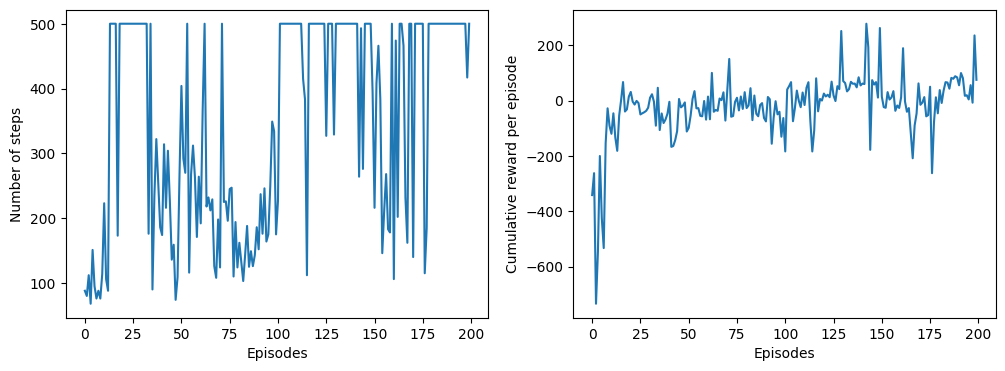

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(episodes_length)
ax[0].set_xlabel("Episodes")
ax[0].set_ylabel("Number of steps")

ax[1].plot(episodes_reward)
ax[1].set_xlabel("Episodes")
ax[1].set_ylabel("Cumulative reward per episode")
plt.show()

#### Let's see the trained agent in action

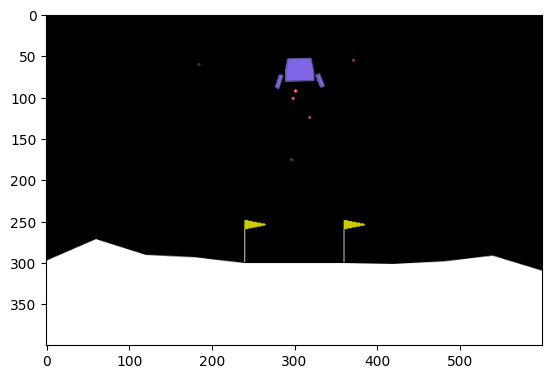

In [61]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
state, info = env.reset()
img = plt.imshow(env.render())

# Load model weights
policy_net = QNet(state_size=env.observation_space.shape[0], n_actions=env.action_space.n)
policy_net.load_state_dict(torch.load("QNet_weights.pth"))

state, info = env.reset()
state = torch.tensor(state).unsqueeze(0)
while True:
    # Choose action
    action = epsilon_greedy_nn(state, policy_net=policy_net, epsilon=0)
    
    # Take action
    next_state, reward, terminated, truncated, _ = env.step(action)

    # Render new state
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if terminated or truncated:
        break
    else:
        next_state = torch.tensor(next_state).unsqueeze(0)

    # Move to the next state
    state = next_state

#### How can we improve the learning speed?

- reduce $\epsilon$ over time, as the agent learns.
- "soft" update the target network parameters instead of "hard" copy.
- better hyperparameters tuning.
- try different net architectures and optimizers.
- other RL methods (e.g., DoubleDQN).
- You can take inspiration from [here](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

**TODO at home**: improve learning speed.